In [ ]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=de3c33196001db72865c012329102c7b34dd14fb96de12cf965c8afce55fb170
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark import SparkFiles
from pyspark.sql.functions import substring, col, avg, month, year
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
# Initialize SparkSession
spark = SparkSession.builder \
    .appName("USD_IDR_Linear_Regression") \
    .getOrCreate()

In [ ]:
url = "https://raw.githubusercontent.com/samkoba/Ubakrie/main/dataset_usdidr_2014-2024.csv"
spark.sparkContext.addFile(url)

In [ ]:
df = spark.read.csv(SparkFiles.get("dataset_usdidr_2014-2024.csv"), header=True, inferSchema=True)
df.printSchema()
df.show(5)

root
 |-- DATE: timestamp (nullable = true)
 |-- OPEN: double (nullable = true)
 |-- HIGH: double (nullable = true)
 |-- LOW: double (nullable = true)
 |-- CLOSE: double (nullable = true)

+-------------------+-------+-------+-------+-------+
|               DATE|   OPEN|   HIGH|    LOW|  CLOSE|
+-------------------+-------+-------+-------+-------+
|2024-05-01 00:00:00|16260.0|16283.0|15881.0|16257.0|
|2024-04-01 00:00:00|15880.0|16350.0|15825.0|16260.0|
|2024-03-01 00:00:00|15700.0|15915.0|15462.0|15879.0|
|2024-02-01 00:00:00|15768.0|15804.0|15548.0|15701.0|
|2024-01-01 00:00:00|15390.0|15869.0|15390.0|15767.0|
+-------------------+-------+-------+-------+-------+
only showing top 5 rows



In [ ]:
# Konversi kolom DATE ke format yang sesuai dan ambil tahun dan bulan
df = df.withColumn("DATE", F.to_date(col("DATE"), "yyyy-MM-dd"))
df = df.withColumn("YEAR", year(col("DATE")))
df = df.withColumn("MONTH", month(col("DATE")))

# Aggregate data
monthly_df = df.groupBy("YEAR", "MONTH").agg(avg("CLOSE").alias("CLOSE"))
monthly_df = monthly_df.orderBy(col("YEAR").desc())

In [ ]:
# Menggunakan VectorAssembler untuk kolom fitur
assembler = VectorAssembler(
    inputCols=["YEAR", "MONTH"],
    outputCol="features")

# Transform data untuk menambahkan kolom fitur
monthly_df = assembler.transform(monthly_df)

# Split data menjadi data pelatihan dan data uji
train_data, test_data = monthly_df.randomSplit([0.8, 0.2], seed=1234)

# Inisialisasi model Regresi Linear
lr = LinearRegression(featuresCol="features", labelCol="CLOSE", elasticNetParam=0.8)

# Melatih model
lr_model = lr.fit(train_data)

# Prediksi pada data test
predictions = lr_model.transform(test_data)

# Menampilkan koefisien dan intercept
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [309.8508835617126,37.30754098770415]
Intercept: -611716.1539561027


In [ ]:
# Evaluasi model
evaluator_rmse = RegressionEvaluator(labelCol="CLOSE", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data: {:.3f}".format(rmse))

evaluator_r2 = RegressionEvaluator(labelCol="CLOSE", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print("R-squared (R2) on test data: {:.3f}".format(r2))

Root Mean Squared Error (RMSE) on test data: 479.695
R-squared (R2) on test data: 0.755


In [ ]:
# Membuat DataFrame predictor
future_years_months = [(year, month) for year in range(2025, 2036) for month in range(1, 13)]
future_df = spark.createDataFrame(future_years_months, ["YEAR", "MONTH"])

# Transform untuk menambahkan kolom fitur
future_df = assembler.transform(future_df)

# Prediksi menggunakan model
predictions_future = lr_model.transform(future_df)

predictions_future = predictions_future.withColumn("formatted_prediction", F.format_number("prediction", 3))

predictions_future = predictions_future.orderBy(col("YEAR").desc())

# Menampilkan prediksi
predictions_future.select("YEAR", "MONTH", "formatted_prediction")


DataFrame[YEAR: bigint, MONTH: bigint, formatted_prediction: string]

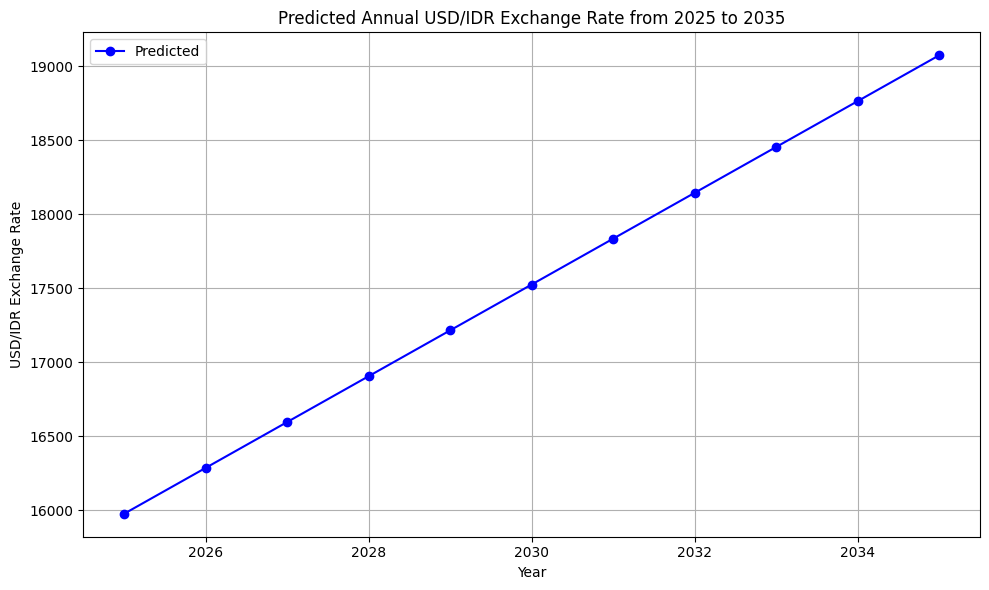

In [ ]:
# Konversi hasil prediksi ke Pandas DataFrame
predicted_df = predictions_future.select("YEAR", "MONTH", "prediction").toPandas()

#Aggregate bulanan ke tahunan
predicted_annual_df = predicted_df.groupby("YEAR").agg({'prediction': 'mean'}).reset_index()

# Plot hasil prediksi
plt.figure(figsize=(10, 6))
plt.plot(predicted_annual_df["YEAR"], predicted_annual_df["prediction"], marker='o', linestyle='-', color='b', label='Predicted')
plt.xlabel('Year')
plt.ylabel('USD/IDR Exchange Rate')
plt.title('Predicted Annual USD/IDR Exchange Rate from 2025 to 2035')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

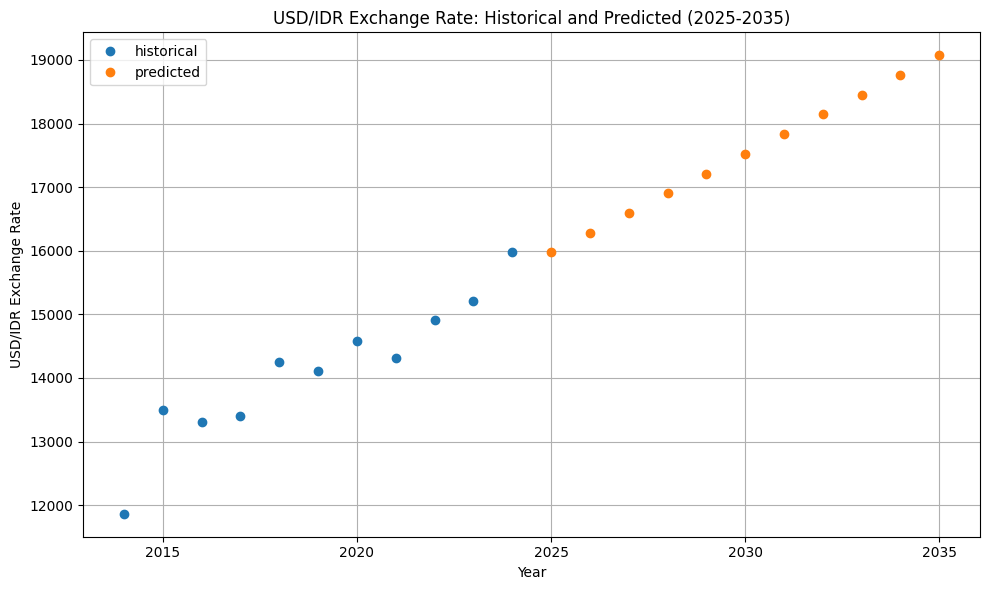

In [ ]:

# Menggabungkan data historis dan prediksi
historical_df = monthly_df.select("YEAR", "CLOSE").toPandas()
historical_df = historical_df.rename(columns={"CLOSE": "value"})
historical_df["type"] = "historical"

predicted_df = predicted_df.rename(columns={"prediction": "value"})
predicted_df["type"] = "predicted"

combined_df = pd.concat([historical_df, predicted_df])

# Plot data historis dan prediksi

historical_df = monthly_df.select("YEAR", "CLOSE").groupBy("YEAR").agg(avg("CLOSE").alias("CLOSE")).toPandas()
historical_df = historical_df.rename(columns={"CLOSE": "value"})
historical_df["type"] = "historical"

predicted_annual_df = predicted_annual_df.rename(columns={"prediction": "value"})
predicted_annual_df["type"] = "predicted"

combined_df = pd.concat([historical_df, predicted_annual_df])

# Plot historical and predicted data
plt.figure(figsize=(10, 6))
for label, df in combined_df.groupby("type"):
    plt.plot(df["YEAR"], df["value"], marker='o', linestyle='', label=label)
plt.xlabel('Year')
plt.ylabel('USD/IDR Exchange Rate')
plt.title('USD/IDR Exchange Rate: Historical and Predicted (2025-2035)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

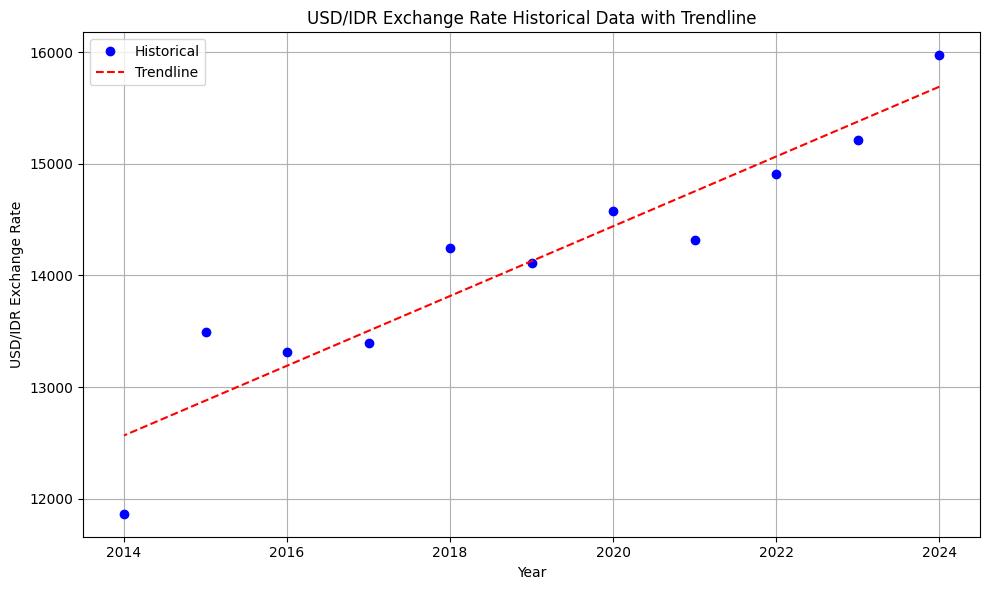

In [ ]:
# Plot data historis dengan trendline
plt.figure(figsize=(10, 6))
plt.plot(historical_df["YEAR"], historical_df["value"], marker='o', linestyle='', color='b', label='Historical')

# Menghitung trendline
z = np.polyfit(historical_df["YEAR"], historical_df["value"], 1)
p = np.poly1d(z)
plt.plot(historical_df["YEAR"], p(historical_df["YEAR"]), linestyle='--', color='r', label='Trendline')

plt.xlabel('Year')
plt.ylabel('USD/IDR Exchange Rate')
plt.title('USD/IDR Exchange Rate Historical Data with Trendline')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()